In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os

# === Step 1: Load and Sample the Dataset ===
INPUT_FILE = "Dataset.csv"
OUTPUT_FILE = "processed_data.csv"
SAMPLE_SIZE = 100_000
RANDOM_SEED = 42

print("[INFO] Loading dataset...")
df = pd.read_csv(INPUT_FILE)
df = df.sample(n=SAMPLE_SIZE, random_state=RANDOM_SEED).reset_index(drop=True)

# === Step 2: Split IP Addresses into Octets ===
def split_ip_column(ip_series, prefix):
    octets = ip_series.str.split('.', expand=True).astype(float)
    octets.columns = [f"{prefix}_octet{i+1}" for i in range(4)]
    return octets

print("[INFO] Splitting IP addresses...")
df_orig_ip = split_ip_column(df["id.orig_h"], "orig_ip")
df_resp_ip = split_ip_column(df["id.resp_h"], "resp_ip")

df = pd.concat([df, df_orig_ip, df_resp_ip], axis=1)
df.drop(columns=["id.orig_h", "id.resp_h"], inplace=True)

# === Step 3: One-Hot Encode Categorical Features ===
print("[INFO] One-hot encoding categorical columns...")
categorical_cols = ["proto", "conn_state", "history", "label"]
df = pd.get_dummies(df, columns=categorical_cols)

# === Step 4: Scale Numerical Features ===
print("[INFO] Scaling numerical features...")
scaler = MinMaxScaler()

# Identify numeric columns (all except one-hot encoded)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# === Step 5: Save the Processed Dataset ===
print(f"[INFO] Saving processed dataset to {OUTPUT_FILE}...")
df.to_csv(OUTPUT_FILE, index=False)
print("[SUCCESS] Preprocessing complete. File saved.")

[INFO] Loading dataset...
[INFO] Splitting IP addresses...
[INFO] One-hot encoding categorical columns...
[INFO] Scaling numerical features...
[INFO] Saving processed dataset to processed_data.csv...
[SUCCESS] Preprocessing complete. File saved.


[INFO] Starting training from scratch...
[Epoch 1] D Loss: 0.5752 | G Loss: 0.8207
[Epoch 2] D Loss: 0.6267 | G Loss: 0.8380
[Epoch 3] D Loss: 0.6130 | G Loss: 0.8872
[Epoch 4] D Loss: 0.6786 | G Loss: 0.7560
[Epoch 5] D Loss: 0.6741 | G Loss: 0.7609
[Epoch 6] D Loss: 0.6838 | G Loss: 0.7382
[Epoch 7] D Loss: 0.6818 | G Loss: 0.7419
[Epoch 8] D Loss: 0.6852 | G Loss: 0.7386
[Epoch 9] D Loss: 0.6866 | G Loss: 0.7261
[Epoch 10] D Loss: 0.6908 | G Loss: 0.7109
[Epoch 11] D Loss: 0.6892 | G Loss: 0.7150
[Epoch 12] D Loss: 0.6879 | G Loss: 0.7306
[Epoch 13] D Loss: 0.6852 | G Loss: 0.7309
[Epoch 14] D Loss: 0.6895 | G Loss: 0.7182
[Epoch 15] D Loss: 0.6939 | G Loss: 0.7007
[Epoch 16] D Loss: 0.6931 | G Loss: 0.7007
[Epoch 17] D Loss: 0.6974 | G Loss: 0.6912
[Epoch 18] D Loss: 0.6939 | G Loss: 0.6994
[Epoch 19] D Loss: 0.6907 | G Loss: 0.7115
[Epoch 20] D Loss: 0.6530 | G Loss: 0.8336
[Epoch 21] D Loss: 0.6466 | G Loss: 0.8439
[Epoch 22] D Loss: 0.6873 | G Loss: 0.7222
[Epoch 23] D Loss: 0.6

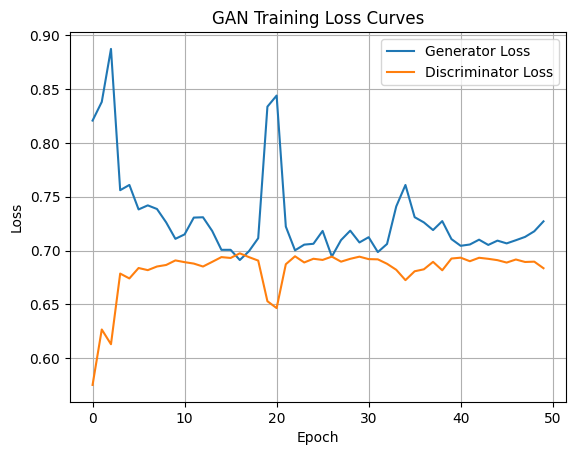

[INFO] Training insights and synthetic data generated.


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ---------------- Configuration ----------------
latent_dim = 100
batch_size = 128
more_epochs = 50
learning_rate = 0.0002
checkpoint_file = "checkpoint.pth"
generated_file = "generated_samples.csv"
scaler_file = "scaler.pkl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Load and Preprocess Data ----------------
df = pd.read_csv("processed_data.csv")

# ✅ Scale data to [-1, 1] for Tanh
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df.values.astype(np.float32))

# ✅ Optional: Save the scaler for later inverse_transform or deployment
import joblib
joblib.dump(scaler, scaler_file)

data_tensor = torch.tensor(data_scaled)
train_loader = DataLoader(TensorDataset(data_tensor), batch_size=batch_size, shuffle=True)
data_dim = data_scaled.shape[1]

# ---------------- Generator ----------------
class Generator(nn.Module):
    def __init__(self, latent_dim, data_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, data_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# ---------------- Discriminator ----------------
class Discriminator(nn.Module):
    def __init__(self, data_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# ---------------- Init Models ----------------
generator = Generator(latent_dim, data_dim).to(device)
discriminator = Discriminator(data_dim).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# ---------------- Resume from Checkpoint ----------------
start_epoch = 0
if os.path.exists(checkpoint_file):
    print(f"[INFO] Resuming training from {checkpoint_file}...")
    try:
        checkpoint = torch.load(checkpoint_file, map_location=device)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
        start_epoch = checkpoint.get('epoch', 0) + 1
    except RuntimeError as e:
        print(f"[WARNING] Checkpoint failed to load. Starting fresh.\n{e}")
        start_epoch = 0
else:
    print("[INFO] Starting training from scratch...")

# ---------------- Training ----------------
criterion = nn.BCELoss()
update_d_every = 2
g_losses, d_losses = [], []

for epoch in range(start_epoch, start_epoch + more_epochs):
    g_loss_total = 0
    d_loss_total = 0

    for i, (real_samples,) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        batch_size = real_samples.size(0)

        real_labels = torch.ones(batch_size, 1).uniform_(0.9, 1.0).to(device)
        fake_labels = torch.zeros(batch_size, 1).uniform_(0.0, 0.1).to(device)

        # Train Generator
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_samples = generator(z)
        fake_pred = discriminator(fake_samples)
        g_loss = criterion(fake_pred, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        g_loss_total += g_loss.item()

        # Train Discriminator
        if i % update_d_every == 0:
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_samples = generator(z).detach()
            real_pred = discriminator(real_samples)
            fake_pred = discriminator(fake_samples)
            d_loss = criterion(real_pred, real_labels) + criterion(fake_pred, fake_labels)

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()
            d_loss_total += d_loss.item()

    avg_d_loss = d_loss_total / len(train_loader)
    avg_g_loss = g_loss_total / len(train_loader)
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    print(f"[Epoch {epoch+1}] D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict()
    }, checkpoint_file)

# ---------------- Save Final Models ----------------
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")
print("[INFO] Final models saved.")

# ---------------- Generate & Save Synthetic Samples ----------------
generator.eval()
with torch.no_grad():
    z = torch.randn(1000, latent_dim).to(device)
    fake_samples = generator(z).cpu().numpy()

# ✅ Inverse scale back to original data range
fake_original_scale = joblib.load(scaler_file).inverse_transform(fake_samples)
pd.DataFrame(fake_original_scale).to_csv(generated_file, index=False)
print(f"[INFO] Saved generated samples to {generated_file}")

# ✅ Simple Insight: Plot training loss curves
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curves")
plt.legend()
plt.grid(True)
plt.savefig("training_loss_plot.png")
plt.show()

print("[INFO] Training insights and synthetic data generated.")
